In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import mean_absolute_error

# Set figure size to (12, 6)
plt.rcParams['figure.figsize'] = (12,6)

# Step 1 - Load and prepare the data

In [2]:
df = pd.read_csv('/Users/braulio/Documents/data/ECA_blended_custom/temp_data.txt')
df.head()

,SOUID,DATE,TG,Q_TG
0,127488,18760101,22,0
1,127488,18760102,25,0
2,127488,18760103,3,0
3,127488,18760104,-58,0
4,127488,18760105,-98,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52777 entries, 0 to 52776
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   SOUID     52777 non-null  int64
 1       DATE  52777 non-null  int64
 2      TG     52777 non-null  int64
 3    Q_TG     52777 non-null  int64
dtypes: int64(4)
memory usage: 1.6 MB


## Temperature Forecast I
Discuss the following questions:

1. What does the temperature forecast for Berlin for any given day depend on? The year? Is there an underlying trend the temperature follows? The day of the year? Does the temperature depend on the season of the year? The temperature of the previous day? Is the present able to explain part of the (near) future?
2. If we know the day of the year, the year and the temperature of the previous day, are we able to perfectly predict the temperature of any given day in Berlin?

## Plot the time series

In [4]:
df.columns

Index(['SOUID', '    DATE', '   TG', ' Q_TG'], dtype='object')

In [5]:
# pd.to_datetime(df['DATE'])
df.columns = ['Source_ID', 'DATE', 'temp', 'q_tg']

In [6]:
df["datetime"] = pd.to_datetime(df["DATE"], format='%Y%m%d')

In [7]:
df.head()

,Source_ID,DATE,temp,q_tg,datetime
0,127488,18760101,22,0,1876-01-01
1,127488,18760102,25,0,1876-01-02
2,127488,18760103,3,0,1876-01-03
3,127488,18760104,-58,0,1876-01-04
4,127488,18760105,-98,0,1876-01-05


In [8]:
df['day'] = df['datetime'].dt.day

df['month'] = df['datetime'].dt.month

df['year'] = df['datetime'].dt.year

In [9]:
df.drop('DATE', axis=1, inplace=True)
df.set_index('datetime', inplace=True)

df.head()

,Source_ID,temp,q_tg,day,month,year
datetime,,,,,,
1876-01-01,127488,22,0,1,1,1876
1876-01-02,127488,25,0,2,1,1876
1876-01-03,127488,3,0,3,1,1876
1876-01-04,127488,-58,0,4,1,1876
1876-01-05,127488,-98,0,5,1,1876


In [10]:
## CONVERT MEAN_TEMP TO KELVIN TO AVOID FUTURE 0 DIVISIONS
df.loc[:,'temp'] *= 0.1
df.loc[:,'temp'] += 273.15

df.head()

,Source_ID,temp,q_tg,day,month,year
datetime,,,,,,
1876-01-01,127488,275.35,0,1,1,1876
1876-01-02,127488,275.65,0,2,1,1876
1876-01-03,127488,273.45,0,3,1,1876
1876-01-04,127488,267.35,0,4,1,1876
1876-01-05,127488,263.35,0,5,1,1876


## Check for missing values
#### Quality code for TG (0='valid'; 1='suspect'; 9='missing')

In [11]:
df[df['q_tg'] == 9]

,Source_ID,temp,q_tg,day,month,year
datetime,,,,,,
1945-04-25,127488,-726.75,9,25,4,1945
1945-04-26,127488,-726.75,9,26,4,1945
1945-04-27,127488,-726.75,9,27,4,1945
1945-04-28,127488,-726.75,9,28,4,1945
1945-04-29,127488,-726.75,9,29,4,1945
...,...,...,...,...,...,...
1945-11-01,127488,-726.75,9,1,11,1945
1945-11-02,127488,-726.75,9,2,11,1945
1945-11-03,127488,-726.75,9,3,11,1945


In [12]:
# values for the same dates with missing values, but from preivous year:
# prev_temps = df['1944-04-25':'1944-11-05']['temp'].values

In [13]:
# values from following year for the same dates with missing values:
# df['1946-04-25':'1946-11-05']['temp'].values

In [14]:
# average between previous year and following year temperature, for the dates with missing values in 1945:
new_val = (df['1946-04-25':'1946-11-05']['temp'].values + df['1944-04-25':'1944-11-05']['temp'].values)*0.5

In [15]:
new_idx = df['1945-04-25':'1945-11-05'].index

In [16]:
s_1945_new = pd.Series(new_val, index = new_idx)
s_1945_new

datetime
1945-04-25    284.65
1945-04-26    286.55
1945-04-27    285.45
1945-04-28    284.30
1945-04-29    283.25
               ...  
1945-11-01    278.55
1945-11-02    278.75
1945-11-03    279.40
1945-11-04    280.25
1945-11-05    280.90
Length: 195, dtype: float64

In [17]:
df.loc['1945-04-25':'1945-11-05', 'temp'] = s_1945_new

In [18]:
df[df['q_tg'] == 9]

,Source_ID,temp,q_tg,day,month,year
datetime,,,,,,
1945-04-25,127488,284.65,9,25,4,1945
1945-04-26,127488,286.55,9,26,4,1945
1945-04-27,127488,285.45,9,27,4,1945
1945-04-28,127488,284.30,9,28,4,1945
1945-04-29,127488,283.25,9,29,4,1945
...,...,...,...,...,...,...
1945-11-01,127488,278.55,9,1,11,1945
1945-11-02,127488,278.75,9,2,11,1945
1945-11-03,127488,279.40,9,3,11,1945


Drop irrelevant column

In [19]:
df['Source_ID'].unique()

array([127488, 111448, 127848, 121152])

In [20]:
df.drop('Source_ID', axis=1, inplace=True)

Dataframe is no ready for plotting!

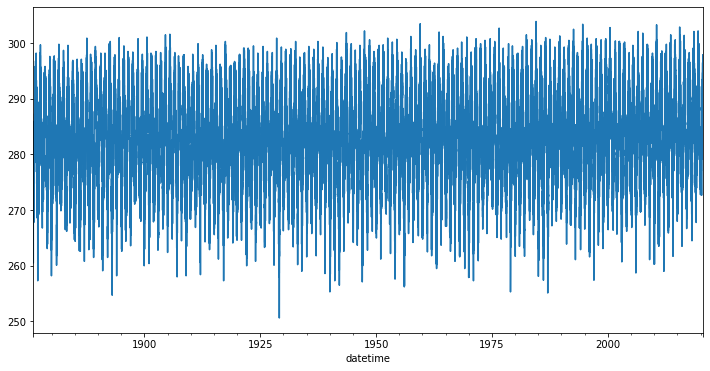

In [21]:
# Plot the series
df['temp'].plot()

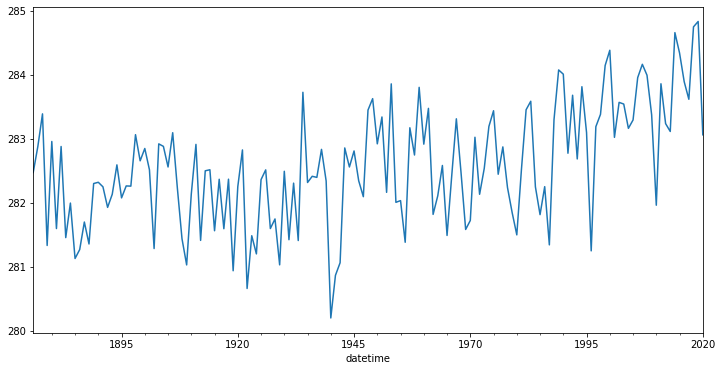

In [22]:
df.resample('y').mean()['temp'].plot()

In [23]:
# Additive decomposition
seasonal = seasonal_decompose(df.resample('y').mean()['temp'])

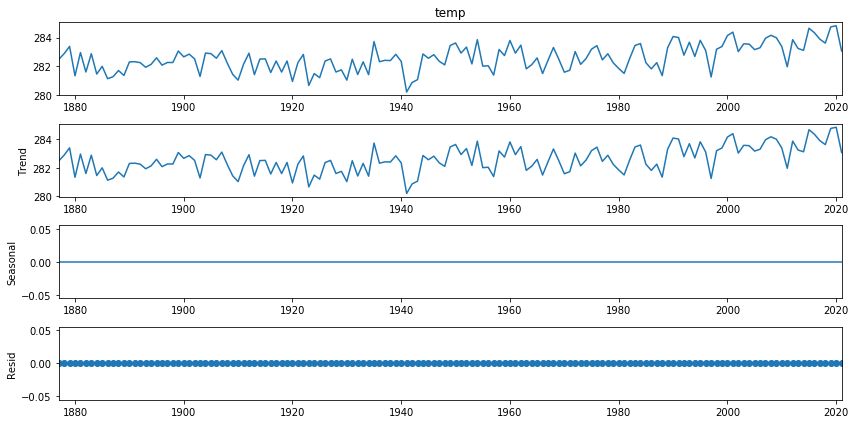

In [24]:
seasonal.plot()
plt.show()

# Step 2 - Split the time series into training and test set

In [25]:
df.tail()

,temp,q_tg,day,month,year
datetime,,,,,
2020-06-26,296.05,0,26,6,2020
2020-06-27,297.95,0,27,6,2020
2020-06-28,294.95,0,28,6,2020
2020-06-29,291.75,0,29,6,2020
2020-06-30,292.35,0,30,6,2020


In [26]:
# If we have a DatetimeIndex as our DataFrame.index, we can use that To slice by dates
y_train = df[:'2019-06-30'].copy()
y_test = df['2019-07-01':'2020-06-30'].copy()

In [27]:
y_train.shape, y_test.shape

((52411, 5), (366, 5))

# Step 3 - Detrend your time series data

In [28]:
# Create the differencing
y_train['temp_diff'] = y_train['temp'].diff()

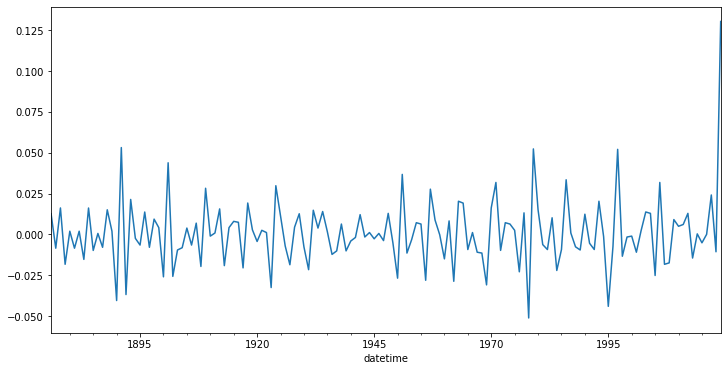

In [29]:
# Plot the time series without trend
y_train.resample('y').mean()['temp_diff'].plot()

## The mean of the detrended time series

In [30]:
# Create the pct_change
y_train['pct_change'] = y_train['temp'].pct_change()

In [31]:
# Take the mean percentage change
y_test['y_pred_mean_pct_change'] = y_train['pct_change'].mean()

# Step 4 - De-seasonalize the series by subtracting monthly means

In [32]:
# Create monthly means of the pct_change
y_train['monthly_means'] = y_train.groupby('month')['pct_change'].transform('mean')

#y_train.head(5)

In [33]:
# Subtract the monthly mean from the actual values
y_train['deseasonalized'] = y_train['pct_change'] - y_train['monthly_means']

#y_train.head()

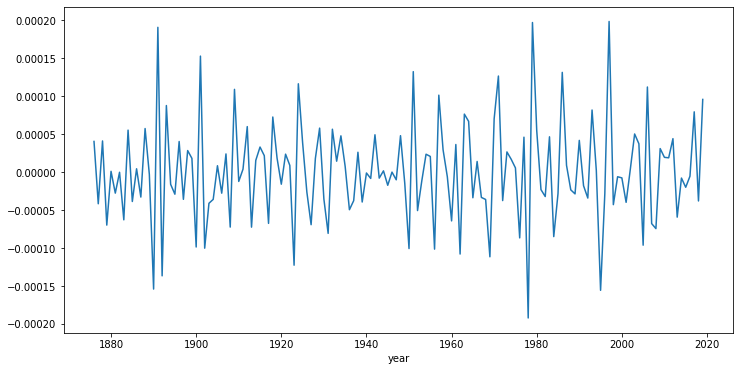

In [34]:
# Plot the deseasonalized data
y_train.groupby('year').mean()['deseasonalized'].plot()

## Temperature Forecast II
Which information is most useful for predicting tomorrows temperature in Berlin?

The temperature in Berlin one year ago?

The long term average temperature in Berlin of tomorrows date?

Todays temperature in Berlin?

## The mean of the time series

In [35]:
y_train['temp'].mean()

282.5429833431899

In [36]:
# Add the mean value of passengers as prediction for y_test
y_test['y_pred_mean'] = y_train['temp'].mean()

y_test.head(5)

,temp,q_tg,day,month,year,y_pred_mean_pct_change,y_pred_mean
datetime,,,,,,,
2019-07-01,295.55,0,1,7,2019,0.000038,282.542983
2019-07-02,290.85,0,2,7,2019,0.000038,282.542983
2019-07-03,288.55,0,3,7,2019,0.000038,282.542983
2019-07-04,290.05,0,4,7,2019,0.000038,282.542983
2019-07-05,291.35,0,5,7,2019,0.000038,282.542983


In [37]:
# Define a function that plots the forecast for us

def plot_forecast(y_train, y_test, columns):
    '''
    Plots forecasts of passenger data
    
    Params:
    -------
    y_train: The training data
    y_test: The test data
    columns: Name of the prediction columns form a DataFrame
    
    '''
    # Plot the actual values
    y_train.resample('y').mean().temp.plot(label='Training Data')
    y_test.resample('y').mean().temp.plot(label=('Test Data'))
    
    # Plot each prediction
    for column in columns:
        y_test[column].plot(label=column)
    
    # General settings
    plt.title('Average temperature over Time', fontsize=15)
    plt.ylabel('Mean temperature', fontsize=12)
    plt.xlabel('Date', fontsize=12)
    plt.legend()
    # plt.savefig('mean_baseline.png')
    plt.show()

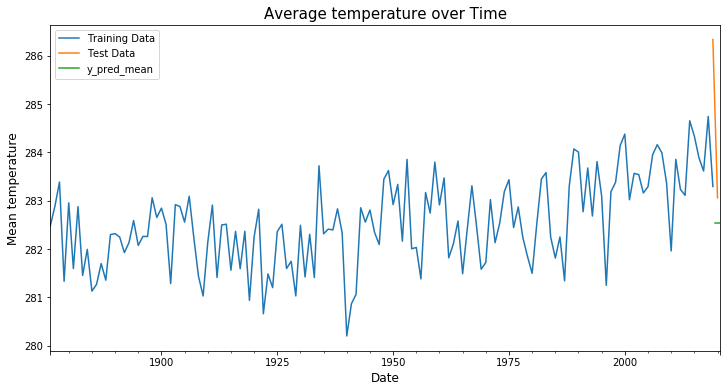

In [38]:
# Plot the forecast
plot_forecast(y_train, y_test, ['y_pred_mean'])

### Convert the prediction back to Mean Temperature

In [39]:
# Add 1 to y_pred_mean_diff
y_test['y_pred_mean_pct_change'] += 1

y_test.head(3)

,temp,q_tg,day,month,year,y_pred_mean_pct_change,y_pred_mean
datetime,,,,,,,
2019-07-01,295.55,0,1,7,2019,1.000038,282.542983
2019-07-02,290.85,0,2,7,2019,1.000038,282.542983
2019-07-03,288.55,0,3,7,2019,1.000038,282.542983


In [40]:
# Take the cumulative product of the series
y_test['y_pred_mean_pct_change'] = np.cumprod(y_test['y_pred_mean_pct_change'])

y_test.head()

,temp,q_tg,day,month,year,y_pred_mean_pct_change,y_pred_mean
datetime,,,,,,,
2019-07-01,295.55,0,1,7,2019,1.000038,282.542983
2019-07-02,290.85,0,2,7,2019,1.000076,282.542983
2019-07-03,288.55,0,3,7,2019,1.000115,282.542983
2019-07-04,290.05,0,4,7,2019,1.000153,282.542983
2019-07-05,291.35,0,5,7,2019,1.000191,282.542983


In [41]:
# Take the last actual observation as starting point
last_observation = y_train['temp'][-1]
last_observation

302.04999999999995

In [42]:
y_test['y_pred_mean_pct_change'] *= last_observation

y_test.head()

,temp,q_tg,day,month,year,y_pred_mean_pct_change,y_pred_mean
datetime,,,,,,,
2019-07-01,295.55,0,1,7,2019,302.061542,282.542983
2019-07-02,290.85,0,2,7,2019,302.073085,282.542983
2019-07-03,288.55,0,3,7,2019,302.084629,282.542983
2019-07-04,290.05,0,4,7,2019,302.096172,282.542983
2019-07-05,291.35,0,5,7,2019,302.107717,282.542983


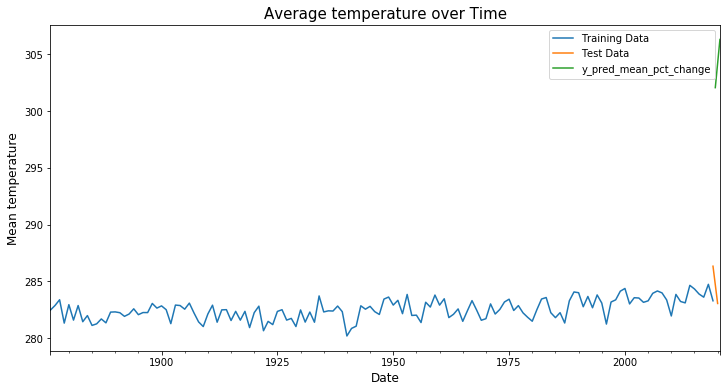

In [43]:
# Plot the forecast
plot_forecast(y_train, y_test, ['y_pred_mean_pct_change'])

## Linear Autoregressive Model


What is X and y?:


* X - past numbers of passengers
* y - future number of passengers

In [44]:
#del y_train['pct_change']
#del y_train['monthly_means']
#del y_train['deseasonalized']

y_train.head()

,temp,q_tg,day,month,year,temp_diff,pct_change,monthly_means,deseasonalized
datetime,,,,,,,,,
1876-01-01,275.35,0,1,1,1876,NaN,NaN,0.000023,NaN
1876-01-02,275.65,0,2,1,1876,0.3,0.001090,0.000023,0.001066
1876-01-03,273.45,0,3,1,1876,-2.2,-0.007981,0.000023,-0.008004
1876-01-04,267.35,0,4,1,1876,-6.1,-0.022308,0.000023,-0.022331
1876-01-05,263.35,0,5,1,1876,-4.0,-0.014962,0.000023,-0.014985


In [45]:
y_test

,temp,q_tg,day,month,year,y_pred_mean_pct_change,y_pred_mean
datetime,,,,,,,
2019-07-01,295.55,0,1,7,2019,302.061542,282.542983
2019-07-02,290.85,0,2,7,2019,302.073085,282.542983
2019-07-03,288.55,0,3,7,2019,302.084629,282.542983
2019-07-04,290.05,0,4,7,2019,302.096172,282.542983
2019-07-05,291.35,0,5,7,2019,302.107717,282.542983
...,...,...,...,...,...,...,...
2020-06-26,296.05,0,26,6,2020,306.257315,282.542983
2020-06-27,297.95,0,27,6,2020,306.269018,282.542983
2020-06-28,294.95,0,28,6,2020,306.280721,282.542983


In [46]:
y_train['t-1'] = y_train['temp'].shift(1)
y_train['t-2'] = y_train['temp'].shift(2)
y_train['t-3'] = y_train['temp'].shift(3)

In [47]:
y_train = y_train.dropna()

In [48]:
y_train.head()

,temp,q_tg,day,month,year,temp_diff,pct_change,monthly_means,deseasonalized,t-1,t-2,t-3
datetime,,,,,,,,,,,,
1876-01-04,267.35,0,4,1,1876,-6.1,-0.022308,0.000023,-0.022331,273.45,275.65,275.35
1876-01-05,263.35,0,5,1,1876,-4.0,-0.014962,0.000023,-0.014985,267.35,273.45,275.65
1876-01-06,265.45,0,6,1,1876,2.1,0.007974,0.000023,0.007951,263.35,267.35,273.45
1876-01-07,266.55,0,7,1,1876,1.1,0.004144,0.000023,0.004121,265.45,263.35,267.35
1876-01-08,264.25,0,8,1,1876,-2.3,-0.008629,0.000023,-0.008652,266.55,265.45,263.35


In [49]:
X = y_train[['t-1', 't-2', 't-3']]
y = y_train['temp']

In [50]:
m = LinearRegression()
m.fit(X, y)
m.score(X, y)   # R^2

0.9109535141055347

In [51]:
m.coef_, m.intercept_

(array([ 1.00491689, -0.20702731,  0.16096683]), 11.625405472100624)

In [52]:
y_train['y_pred_ar'] = m.predict(X)

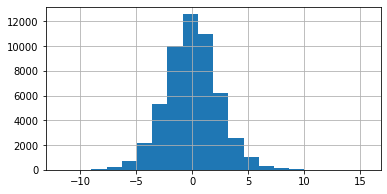

In [53]:
(y_train['y_pred_ar'] - y_train['temp']).hist(bins=20, figsize=(6,3))

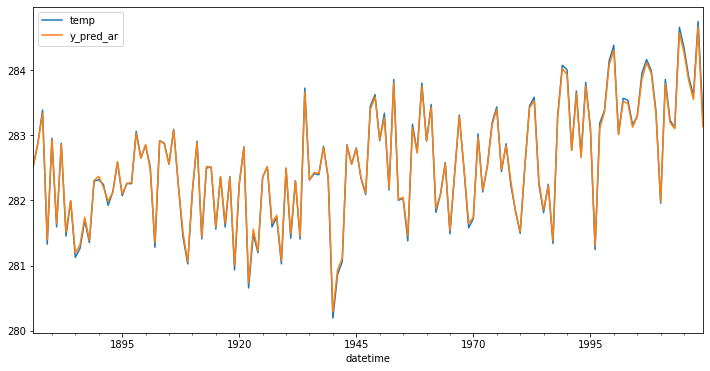

In [54]:
y_train.resample('y').mean()[['temp', 'y_pred_ar']].plot()

In [55]:
print(f'The mean absolute error of {y_pred_ar} is')
print(f'{mean_absolute_error(y_test["temp"], y_test["y_pred_ar"])}')

NameError: name 'y_pred_ar' is not defined

In [56]:
predictions = y_test.columns[5:]

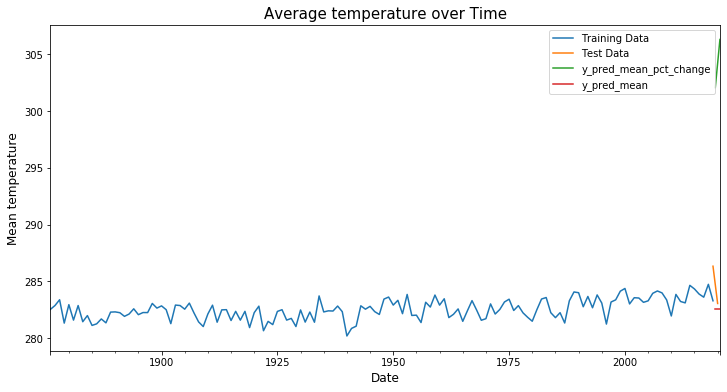

In [57]:
plot_forecast(y_train, y_test, predictions)

In [58]:
for prediction in predictions:
    print(f'The mean absolute error of {prediction} is')
    print(f'{mean_absolute_error(y_test["temp"], y_test[prediction])}')
    print()

The mean absolute error of y_pred_mean_pct_change is
19.469175448531814

The mean absolute error of y_pred_mean is
5.779373860219955

